## Conclusiones

### Librerías

In [134]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

### Lectura y preprocesamiento de datos

In [135]:
df = pd.read_csv('mission_launches.csv').drop(columns=['Unnamed: 0.1','Unnamed: 0'])

df.rename(columns={'Company Name':'company',
                   'Location':'launch_spot',
                   'Datum':'date',
                   'Detail':'detail',
                   'Status Rocket':'rocket_status',
                   ' Rocket':'cost',
                   'Status Mission':'mission_status'},
          inplace=True)

##-----Verificar cuántos valores nulos y/o duplicados hay

def missing_values(df):
    doubles = df.duplicated().sum()
    size = df.shape[0]
    print(f'El conjunto de datos tiene {size} registros, {df.shape[1]} columnas y {doubles} valores duplicados'.center(80,'-'))
    print('')
    df = df.drop_duplicates()
    for i,col in enumerate(df):
        missing = df[col].isna().sum()
        missing_percentage = missing/size*100

        print(f'La columna {col} tiene --> {missing} valores nulos equivalentes al --> {missing_percentage:.2f}% <-- del total de datos.')
    return df

df = missing_values(df)

--El conjunto de datos tiene 4324 registros, 7 columnas y 1 valores duplicados--

La columna company tiene --> 0 valores nulos equivalentes al --> 0.00% <-- del total de datos.
La columna launch_spot tiene --> 0 valores nulos equivalentes al --> 0.00% <-- del total de datos.
La columna date tiene --> 0 valores nulos equivalentes al --> 0.00% <-- del total de datos.
La columna detail tiene --> 0 valores nulos equivalentes al --> 0.00% <-- del total de datos.
La columna rocket_status tiene --> 0 valores nulos equivalentes al --> 0.00% <-- del total de datos.
La columna cost tiene --> 3360 valores nulos equivalentes al --> 77.71% <-- del total de datos.
La columna mission_status tiene --> 0 valores nulos equivalentes al --> 0.00% <-- del total de datos.


### Información inicial

* El dataset tiene 4324 registros y 7 columnas. 
* La columna con el costo de cada misión tiene 77.71% de datos nulos. 
* Se tomarán 2 escenarios, uno donde se reemplazan esos valores nulos con el promedio (df_p) y otro donde se descarta la columna (df).


In [136]:
##-----Conversión de datos


#-----Eliminar 'UTC' de la columna date

df['date'] = df['date'].str.replace(' UTC','')

#-----La columna date tiene datos de tipo date y de tipo datetime. Es necesario hacer la conversión

def date_conversion(x):
    if ':' in x:
        return pd.to_datetime(x,format='%a %b %d, %Y %H:%M')
    else:
        return pd.to_datetime(x,format='%a %b %d, %Y')
    
df['date'] = df['date'].apply(date_conversion)


#-----La columna cost es tipo string y tiene espacios vacíos y comas. Es necesario eliminar los espacios vacios y las comas antes de convertir a numero.


df['cost'] = df['cost'].str.replace(' ','')
df['cost'] = df['cost'].str.replace(',','')
df['cost'] = df['cost'].astype(np.float32)

#-----Reemplazar valores nulos
df['cost'] = df['cost'].fillna(df['cost'].mean())

#-----Obtención de medidas derivadas

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

#-----Obtener el país de lanzamiento de cada misión

df['launch_spot'] = df['launch_spot'].str.split(', ').str[-1]


#-----La columna detail tiene el nombre del cohete y la carga que lleva. Hay que dividirla

df[['rocket','load']] = df['detail'].str.split('|',expand=True)
df = df.drop(columns='detail')


#-----La columna del lugar de lanzamiento tiene algunos lugares que no indican explícitamente el país. Deben ser reemplazados.

changes = {'New Mexico':'USA',
    "Yellow Sea":'China',
    "Shahrud Missile Test Site":'Iran',
    "Pacific Missile Range Facility":'USA',
    "Barents Sea":'Russia',
    "Gran Canaria":'USA'
}

df['launch_spot'] = df['launch_spot'].replace(changes)

#-----Organizar los datos por fecha

df = df.sort_values(by='date').reset_index(drop=True)


##Optimizar el codigo borrando variables que ya no serán usadas
del  changes

## Estilos estéticos

In [137]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["font.family"]="serif"
mpl.rcParams["axes.edgecolor"]="0.2"

mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=12
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False


### Análisis exploratorio de datos

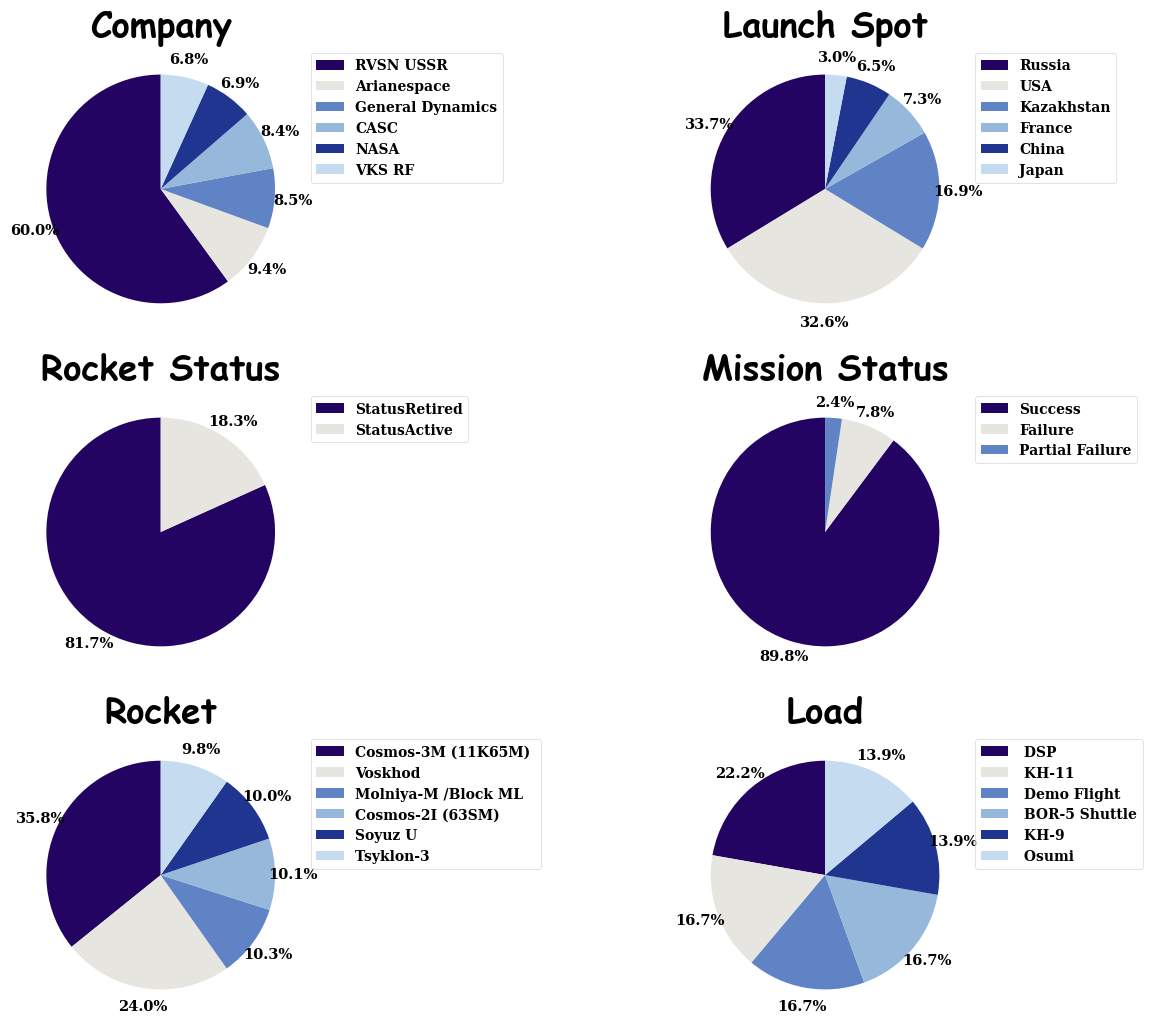

In [138]:
#-----Distribución de los datos categóricos
cat = df.select_dtypes('O')

fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(14,12))
ax = ax.flat

colors = ['#230462','#e6e5e0','#6083c5','#96b8db','#203590','#c5dbf0','#76949f']
for i, col in enumerate(cat):
    if col!='mission_status':
        cat[col].value_counts(sort=True).head(6).plot(kind='pie',ax=ax[i],
                        autopct='%.1f%%',labeldistance=None,pctdistance=1.16,
                        radius=1,startangle=90,colors=colors)
    else:
        cat[col].value_counts(sort=True).head(3).plot(kind='pie',ax=ax[i],
                        autopct='%.1f%%',labeldistance=None,pctdistance=1.14,
                        radius=1,startangle=90,colors=colors)
    ax[i].set_ylabel('')
    ax[i].set_title(f'{col}'.title().replace('_',' '),fontfamily='cursive')
    ax[i].legend(bbox_to_anchor=(1,1),fontsize=10)

plt.show()


##Optimizar el codigo borrando variables que ya no serán usadas
del  cat

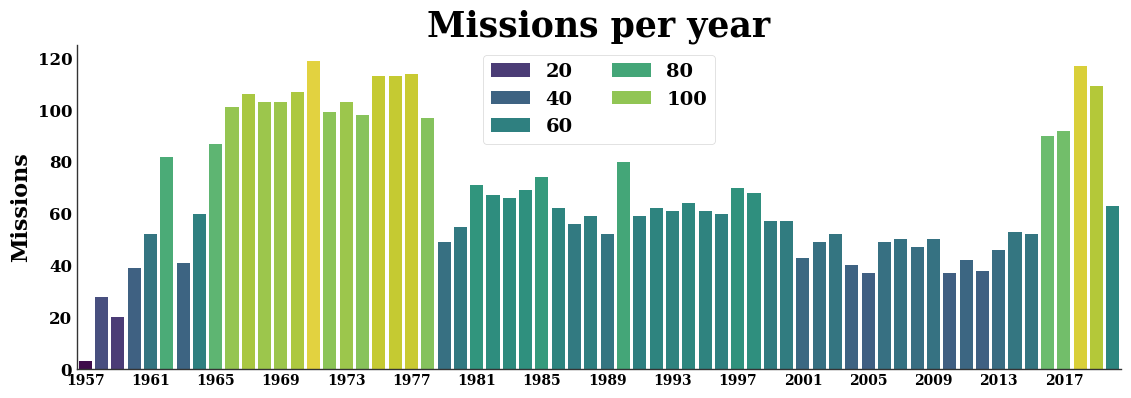

In [139]:
#-----Misiones por año

fig, ax = plt.subplots(figsize=(12,4))

missions_per_year = df.groupby('year')['rocket'].count().reset_index()

bar = sns.barplot(data=missions_per_year,x='year',y='rocket',ax=ax,hue='rocket',palette='viridis',legend='auto')
# ##Etiquetas
# # for container in bar.containers:
# #     ax.bar_label(container,fontsize=9,rotation=0,padding=10,label_type='edge',bbox=dict(facecolor='w',boxstyle='round,pad=0.15',edgecolor='k'),)

ax.set_title('Missions per year')
ax.set_xlabel('')
ax.set_ylabel('Missions')
ax.legend(ncols=2)
ticks = np.arange(0,missions_per_year.shape[0],4)
labels = missions_per_year.iloc[::4,0]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

ax.spines[['top','right']].set_visible(False)


##Optimizar el codigo borrando variables que ya no serán usadas
del  missions_per_year,ticks,labels,bar

In [140]:
# ingredientes = ['ml de agua', 'gramos de tomate', 'gramos de cebolla', 
#                 'gramos de pepino', 'gramos de uranio', 'gramos de ayudante_de_santa', 
#                 'gramos de coliflor', 'gramos de avena']

# cantidades_gramos = [100,150,200,300,400,50]
# productos = ['Salsa de arandanos baja en grasa','Salsa de arandanos baja en salsa','salsa de pepino alta en piña','pechuga alta en cerdo']

# producto = input('Ingrese el producto: ')

# for i in range(len(productos)):
#     if 'arandanos baja en grasa' in productos[i]:
#         print(f'El producto es {productos[i]}.'.center(60,'-'))
#         print(f'Los ingredientes son: {list(zip(cantidades_gramos[1:7:2],ingredientes[1:7:2]))}')
#         break
#     elif 'alta en piña' in productos[i]:
#         print(f'El producto es {productos[i]}.'.center(60,'-'))
#         print(f'Los ingredientes son: {list(zip(cantidades_gramos[1:7:2],ingredientes[1:7:2]))}')

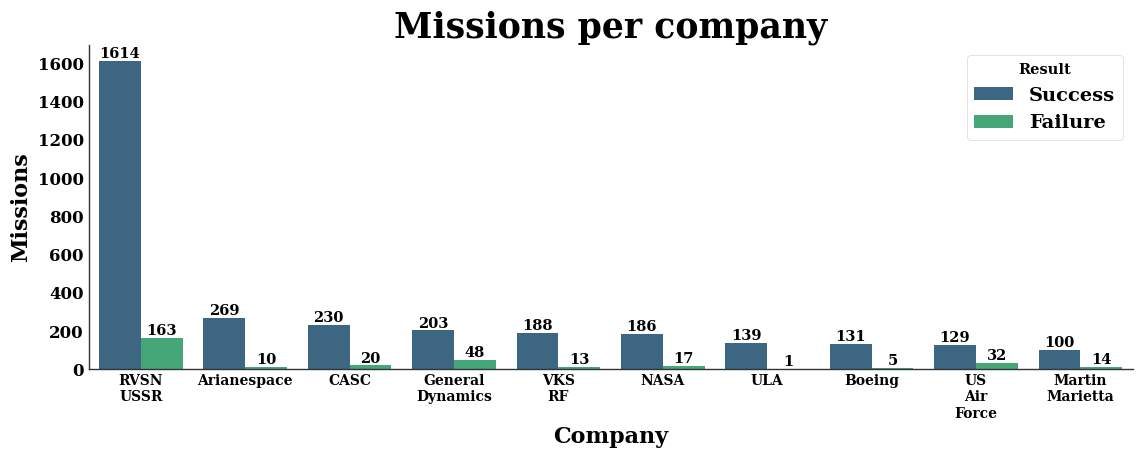

In [141]:
##Misiones por compañías con más misiones y resultado de la mision

##Creamos una nueva columna con éxito o fracaso de la misión
df['success'] = df['mission_status'].apply(lambda x:'Success' if x=='Success' else 'Failure')

##Determinar cuales son las compañias con más misiones
more_missions = df['company'].value_counts(sort=True).head(10).index
companies_missions = df.loc[df['company'].isin(more_missions)].groupby(['company','success'])['rocket'].count().reset_index().sort_values(by='rocket',ascending=False)


fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=companies_missions,x='company',y='rocket',hue='success',errorbar=None,palette='viridis')

for container in bar.containers:
    ax.bar_label(container)

labels = [i.replace(' ','\n') for i in companies_missions['company'].unique()]
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Company')
ax.set_ylabel('Missions')
ax.set_title('Missions per company')
ax.legend(title='Result')
ax.spines[['top','right']].set_visible(False)
plt.show()

##Optimizar el codigo borrando variables que ya no serán usadas
del  more_missions,companies_missions

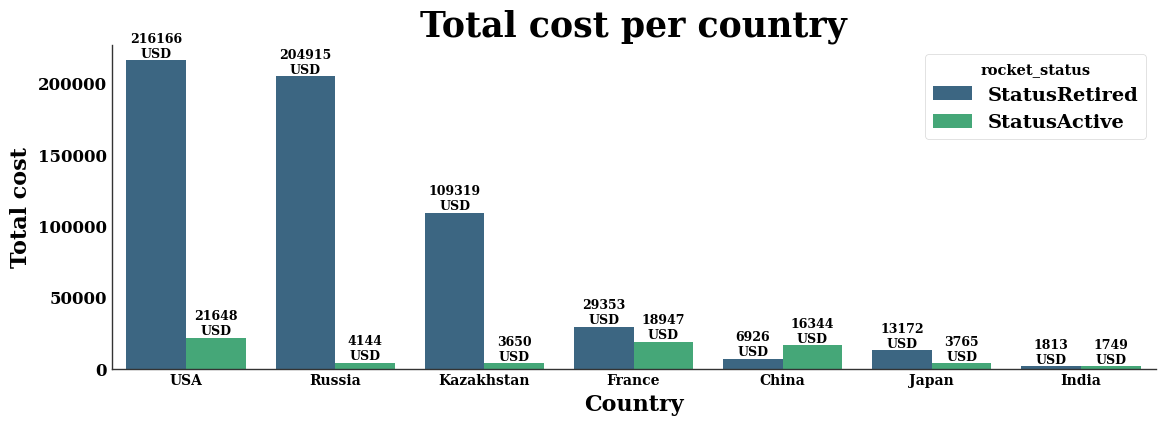

In [183]:
##Mayores costos totales de las misiones por país


##paises que más han gastado
more_cost = df.groupby(['launch_spot'])['cost'].sum().sort_values(ascending=False).head(8).drop(index='Pacific Ocean').index
total_cost = df.loc[df['launch_spot'].isin(more_cost)].groupby(['launch_spot','rocket_status'])['cost'].sum().reset_index().sort_values(by='cost',ascending=False)

fig, ax = plt.subplots(figsize=(12,4))
bar= sns.barplot(data=total_cost,x='launch_spot',y='cost',errorbar=None,hue='rocket_status',palette='viridis')

for container in bar.containers:
    ax.bar_label(container,fmt=lambda x:f'{x:.0f}\nUSD',fontsize=9)
ax.spines[['top','right']].set_visible(False)

ax.set_xlabel('Country')
ax.set_ylabel('Total cost')
ax.set_title('Total cost per country')

plt.show()

del bar, more_cost,total_cost

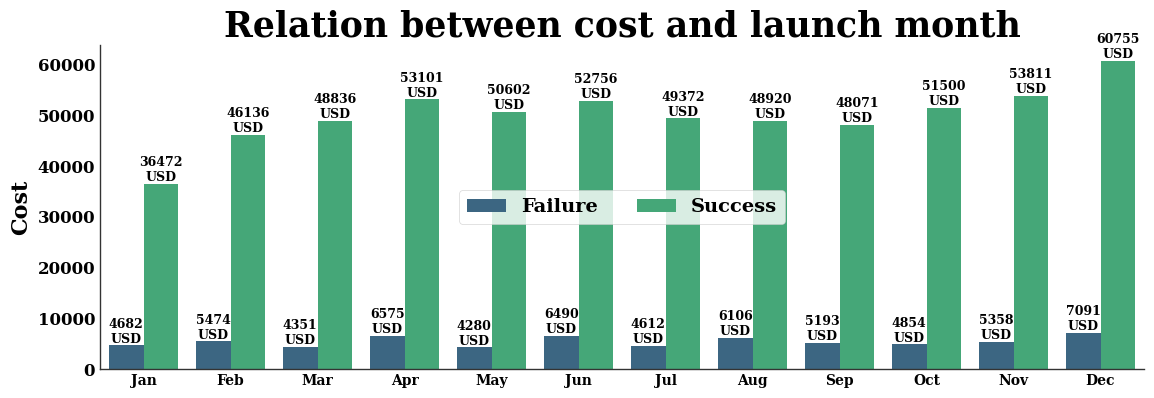

In [204]:
month_success = df.groupby(['month','success'])['cost'].sum().reset_index()

fig, ax = plt.subplots(figsize=(12,4))

bar = sns.barplot(data=month_success,x='month',y='cost',hue='success',errorbar=None,palette='viridis')

for container in bar.containers:
    ax.bar_label(container,fmt=lambda x:f'{x:.0f}\nUSD',fontsize=9)
ax.spines[['top','right']].set_visible(False)
ax.legend(ncols=2,loc='center')
ax.set_xlabel('')
ax.set_title('Relation between cost and launch month')
ax.set_ylabel('Cost')

labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
plt.show()

del bar, month_success

### Implementación de Machine Learning - en proceso

In [26]:
## Vamos a determinar qué estado puede tener una misión (Succes, Failure, Partial fealure, prelauch fealure) basado en la compañia que lanza y el año de lanzamiento.

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split


df_cat = df.select_dtypes('O')

encoder = LabelEncoder()

for col in df_cat:
    df[col] = encoder.fit_transform(df[col].astype(str))

x = df[['company','year']]
y = df['mission_status']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=123)

decision_tree = DecisionTreeClassifier(max_depth=5)

decision_tree.fit(x_train,y_train)

y_predict = decision_tree.predict(x_test)

In [27]:
matrix = confusion_matrix(y_test, y_predict)
f1  = f1_score(y_test, y_predict,average='micro')
f1

0.9067796610169492

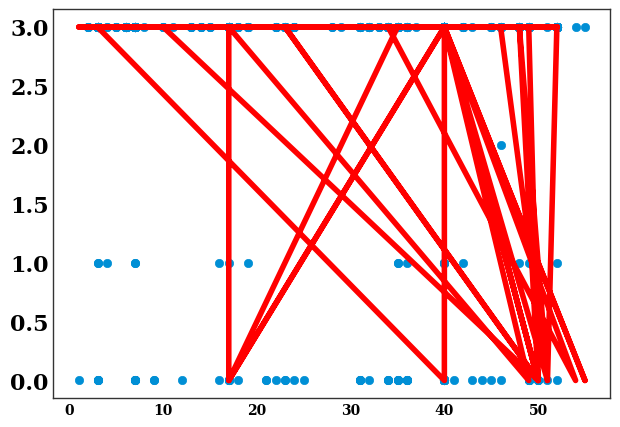

In [28]:
plt.scatter(x_test['company'],y_test)
plt.plot(x_test['company'],y_predict,color='r')